In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split # , cross_val_score
# from sklearn.metrics import r2_score, make_scorer, mean_squared_error

# from sympy import parse_expr
# from copy import deepcopy


from pyoperon.sklearn import SymbolicRegressor
# from pyoperon import R2, MSE, InfixFormatter, FitLeastSquares, Interpreter


In [79]:
# Read Nikuradse dataset
df = pd.read_csv('nikuradse_2.tsv.gz', sep='\t')
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:, -1])

print(f'X shape: {np.shape(X)}')
print(f'X shape: {np.shape(X)}')


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66)
# X_train, y_train = X[0:231, :], y[0:231]
# X_test, y_test = X[231:361, :], y[231:361]

sErr = 0.05  # estimated value for sigma error (used for model selection)

print(f'X_train shape: {np.shape(X_train)}')
print(f'X_test shape: {np.shape(X_test)}')


X shape: (362, 1)
X shape: (362, 1)
X_train shape: (238, 1)
X_test shape: (124, 1)


In [80]:

reg = SymbolicRegressor(
        allowed_symbols= "add,sub,mul,div,constant,variable",
        population_size= 1000,
        pool_size= 1000,
        generations= 50,
        female_selector= "tournament",
        male_selector= "tournament",
        tournament_size= 3,
        optimizer_iterations= 30,
        optimizer='lm',
        epsilon= 1e-05,
        max_evaluations= 1000000,
        max_length= 50,
        model_selection_criterion= "minimum_description_length",
        mutation_probability= 0.15,
        objectives= [ 'r2', 'length' ],
        random_state= None,
        uncertainty= [sErr],
        n_threads=0
        )

reg.fit(X_train, y_train)



SymbolicRegressor(generations=50, max_time=9223372036854775807,
                  mutation_probability=0.15, n_threads=0,
                  objectives=['r2', 'length'], optimizer_iterations=30,
                  pool_size=1000, random_state=2977802845400140511,
                  tournament_size=3, uncertainty=[0.04])

In [81]:

res = [(s['objective_values'], s['tree'], s['minimum_description_length']) for s in reg.pareto_front_]
for obj, expr, mdl in res:
    print(obj, mdl, reg.get_model_string(expr, 16))

m = reg.model_
s = reg.get_model_string(m, 3)
print(s)

[-0.004677910823374987, 5.0] 4203.1123046875 (1.7587060928344727 + (0.0251395925879478 * (0.8844552040100098 * X1)))
[-0.00773428613319993, 7.0] 4193.48779296875 (1.8248510360717773 + (0.1092857271432877 * ((0.4144771397113800 * X1) * ((-0.1855963915586472) * X1))))
[-0.4117153286933899, 9.0] 2281.674560546875 (0.2554417848587036 + ((-0.0104616666212678) * (((-185.3835296630859375) * X1) / ((1.1552715301513672 * X1) - (-0.1124719679355621)))))
[-0.6168841123580933, 11.0] 1312.9732666015625 (0.3925811648368835 + (0.5004147887229919 * (((5.9019069671630859 * X1) / ((1.3399424552917480 * X1) - (-0.4578520357608795))) + ((-0.3935047090053558) * X1))))
[-0.8080642223358154, 13.0] 406.5998229980469 (0.2768271267414093 + (10.4626884460449219 * ((((-7.8533039093017578) * X1) / ((0.4989816844463348 * X1) - (-0.6027991771697998))) / (((-20.4415321350097656) * X1) - 24.1571636199951172))))
[-0.9209272861480713, 15.0] -122.8186264038086 (0.8756437897682190 + (7.3049435615539551 * (((0.264503836631

RMSE (training): 0.0392
RMSE (test): 0.044
(238,)


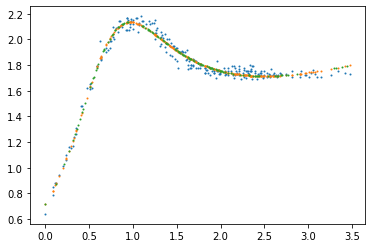

In [82]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

r_train = (y_train - y_train_pred)
r_test = (y_test - y_test_pred)
MSE_train = 1/len(r_train) * r_train.T @ r_train
MSE_test = 1/len(r_test) * r_test.T @ r_test
print(f'RMSE (training): {math.sqrt(MSE_train):0.3}')
print(f'RMSE (test): {math.sqrt(MSE_test):0.3}')

print(np.shape(y_train_pred))
plt.plot(X_train[:,0], y_train, 'o', label='Target', markersize=1)
plt.plot(X_train[:,0], y_train_pred, 'o', label='Training prediction', markersize=1)
plt.plot(X_test[:,0], y_test_pred, 'o', label='Training prediction', markersize=1)
# plt.legend()
# plt.show()

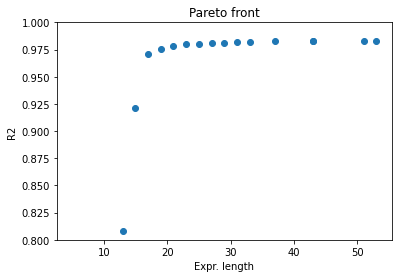

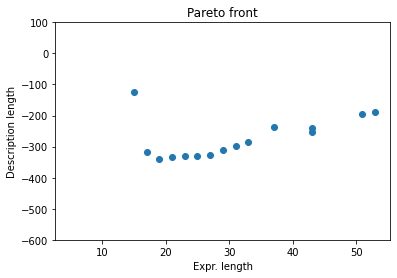

In [83]:
# Pareto front of objective values (R2,length)
values = np.array([t['objective_values'] for t in reg.pareto_front_])
plt.plot(values[:,1], -values[:,0], 'o')
plt.xlabel ('Expr. length')
plt.ylabel ('R2')
plt.title ('Pareto front')
plt.ylim((0.8, 1))
plt.show()

# Description length
values = np.array([(*t['objective_values'], t['minimum_description_length']) for t in reg.pareto_front_])

plt.plot(values[:,1], values[:,2], 'o')
plt.xlabel ('Expr. length')
plt.ylabel ('Description length')
plt.title ('Pareto front')
plt.ylim((-600, 100))
plt.show()
